In [1]:
# import packages
import pandas as pd
import numpy as np

# to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

# setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

# for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [2]:
df = pd.read_csv('../res/input0130.csv')

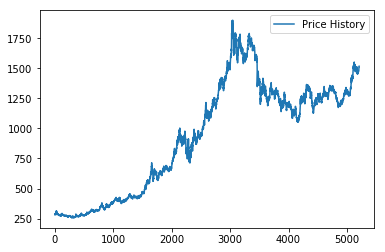

In [3]:
plt.plot(df['close'], label='Price History')
plt.legend()

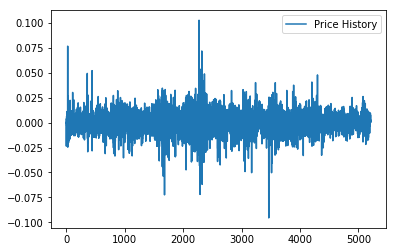

In [4]:
plt.plot(df['log_r'], label='Price History')
plt.legend()

In [22]:
#importing required libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
# follow the literature
# we don't use min-max scaling here, use partial mean-std scaling instead
from sklearn.preprocessing import StandardScaler
from itertools import chain

# and we define our model here
def lstm_model(para_a=42, para_b=17):
    model = Sequential()
    model.add(LSTM(units=para_a, dropout=0.1, return_sequences=True, input_shape=(240,1),activation='tanh'))# (25,15)-57, (42,17)-58
    model.add(LSTM(units=para_b,activation='tanh'))
    model.add(Dropout(0.08))# 加了之后同原先效果差不多，（应该一定程度上）可以防止过拟合
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [23]:
# we use rolling window, 750 bars for train and 250 for test
scaler = StandardScaler()
starter = range(240,len(df)-1000,250)
all_results = []
all_evas = []
y_pred_clf = []

In [29]:
for train_begin in starter:
    train_end = train_begin + 750
    test_end = train_end + 250
    train_set = df[['log_r','label']][train_begin:train_end].reset_index()
    x_train, y_train = [], []
    x_train_set = list(chain.from_iterable(scaler.fit_transform(train_set['log_r'].values.reshape(-1,1))))
    for i in range(240,len(x_train_set)):
        x_train.append(x_train_set[i-240:i])
        y_train.append(train_set['label'][i])
    x_train, y_train = np.array(x_train), np.array(y_train)
    y_train = to_categorical(y_train,2)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) 
    
    model = lstm_model()
    # 原本未设置 batch_size，使用的是默认值，进行尝试：
    # (1)batch_size=8——可达0.62
    # (1)batch_size=18——可达0.58
    # (1)batch_size=5——可达0.60
    # 依然选择 batch_size=8，稳定在0.60左右的水平
    model.fit(x_train,y_train,epochs=30, batch_size=8, callbacks=[EarlyStopping(monitor='loss',patience=10)])

    x_test, y_test = [], []
    test_set = df[['log_r','label']][train_end-240:test_end].reset_index()
    x_test_set = list(chain.from_iterable(scaler.transform(test_set['log_r'].values.reshape(-1,1))))
    for i in range(240,len(x_test_set)):
        x_test.append(x_test_set[i-240:i])
        y_test.append(test_set['label'][i])
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1)) 
    y_test = to_categorical(y_test,2)
    
    all_results.append(model.predict(x_test))
    all_evas.append(model.evaluate(x_test, y_test))
    y_pred_clf.append(model.predict_classes(x_test))
    break

Epoch 1/30
510/510 [==============================] - 16s 31ms/step - loss: 0.6946 - acc: 0.5176
Epoch 2/30
510/510 [==============================] - 14s 27ms/step - loss: 0.6922 - acc: 0.5059
Epoch 3/30
510/510 [==============================] - 15s 29ms/step - loss: 0.6921 - acc: 0.5431
Epoch 4/30
510/510 [==============================] - 16s 31ms/step - loss: 0.6913 - acc: 0.5333
Epoch 5/30
510/510 [==============================] - 14s 28ms/step - loss: 0.6914 - acc: 0.5392
Epoch 6/30
510/510 [==============================] - 15s 29ms/step - loss: 0.6905 - acc: 0.5471
Epoch 7/30
510/510 [==============================] - 15s 30ms/step - loss: 0.6904 - acc: 0.5569
Epoch 8/30
510/510 [==============================] - 15s 29ms/step - loss: 0.6878 - acc: 0.5529
Epoch 9/30
510/510 [==============================] - 15s 29ms/step - loss: 0.6878 - acc: 0.5529
Epoch 10/30
510/510 [==============================] - 15s 30ms/step - loss: 0.6879 - acc: 0.5549
Epoch 11/30
510/510 [========

In [21]:
from sklearn import metrics


for train_begin in starter:
    train_end = train_begin + 750
    test_end = train_end + 250
    train_set = df[['log_r','label']][train_begin:train_end].reset_index()
    x_train, y_train = [], []
    x_train_set = list(chain.from_iterable(scaler.fit_transform(train_set['log_r'].values.reshape(-1,1))))
    for i in range(240,len(x_train_set)):
        x_train.append(x_train_set[i-240:i])
        y_train.append(train_set['label'][i])
    x_train, y_train = np.array(x_train), np.array(y_train)
    # y_train = to_categorical(y_train,2)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) 
    x_test, y_test = [], []
    test_set = df[['log_r','label']][train_end-240:test_end].reset_index()
    x_test_set = list(chain.from_iterable(scaler.transform(test_set['log_r'].values.reshape(-1,1))))
    for i in range(240,len(x_test_set)):
        x_test.append(x_test_set[i-240:i])
        y_test.append(test_set['label'][i])
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1)) 
    y_pred = model.predict_classes(x_train)
    # all_results.append(model.predict(x_test))
    print(metrics.accuracy_score(y_train, y_pred))
    # y_pred_clf.append(model.predict_classes(x_test))

0.5588235294117647
0.5666666666666667
0.5529411764705883
0.5352941176470588
0.5117647058823529
0.5333333333333333
0.5078431372549019
0.5294117647058824
0.5764705882352941
0.5607843137254902
0.5019607843137255
0.503921568627451
0.5176470588235295
0.49607843137254903
0.4980392156862745
0.5313725490196078
